In [113]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.ndimage import convolve, median_filter
from skimage import transform
from scipy import ndimage
from scipy import stats
from numpy.lib.stride_tricks import as_strided
from numpy.typing import NDArray

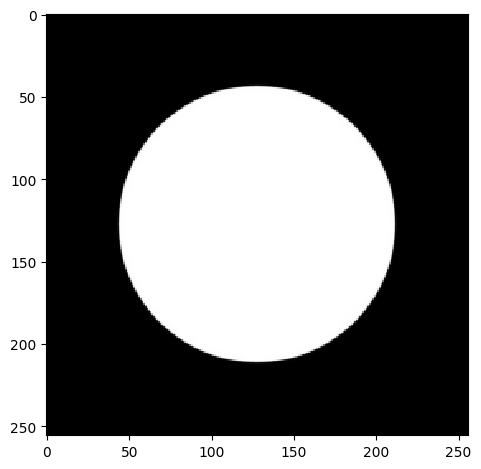

In [99]:
obraz = io.imread(r"C:/Users/matiu/OneDrive/Pulpit/SiOC/Bayer/circl.jpg")
obraz = obraz[:, :, :3] 
obraz = transform.resize(obraz, output_shape=(256, 256, 3))
io.imshow(obraz)

In [131]:
def konwolucja(obraz: NDArray, jadro: NDArray, krok: int) -> NDArray:
    if krok == 1:
        return convolve(obraz, jadro)

    szerokosc, wysokosc = obraz.shape
    szerokosc_jadro, wysokosc_jadro = jadro.shape
    ksztalt = ((szerokosc - szerokosc_jadro) // krok + 1, (wysokosc - wysokosc_jadro) // krok + 1)

    kroki = (krok * obraz.strides[0], krok * obraz.strides[1]) + obraz.strides
    przesuniete = as_strided(obraz, shape=ksztalt + (szerokosc_jadro, wysokosc_jadro), strides=kroki)
    return np.einsum("ijkl,kl->ij", przesuniete, jadro)

In [132]:
def konwolucja_z_krokami(obraz: NDArray, jadro: NDArray, krok: int = 1, padding: int = 0) -> NDArray:

#obraz i jądro jako tablica numpy
#krok do użycia przy konwolucji bardzo ważne
#padding podany w pikselach które będą dodane wokół obrazu

    if padding is not None:
        obraz = np.pad(obraz, padding, mode="constant")
    if obraz.ndim == 3: #kolor
        return np.dstack([konwolucja(obraz[:, :, kanal], jadro, krok) for kanal in range(3)])
    if obraz.ndim == 2:
        return konwolucja(obraz, jadro, krok) #szary
    raise ValueError(f"kształt {obraz.shape} nie obsługiwany")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


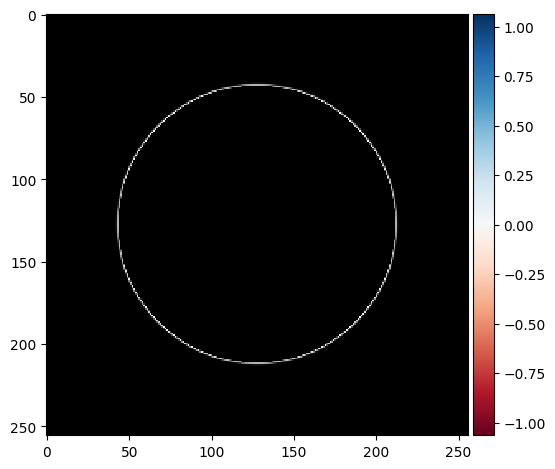

In [102]:
#wykrywanie krawędzi laplace
filtr_laplace = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
obraz_po_konwolucji = konwolucja_z_krokami(obraz, filtr_laplace)
_ = io.imshow(obraz_po_konwolucji)

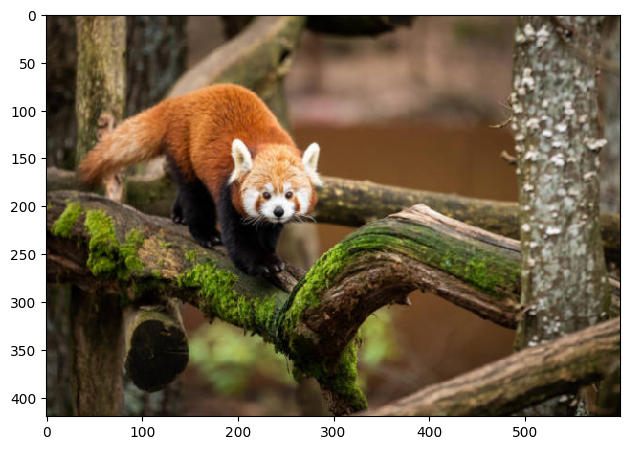

In [104]:
obraz = np.load("C:/Users/matiu/Downloads/CFA_NPY/CFA_NPY/Fuji/panda.npy")
io.imshow(obraz)

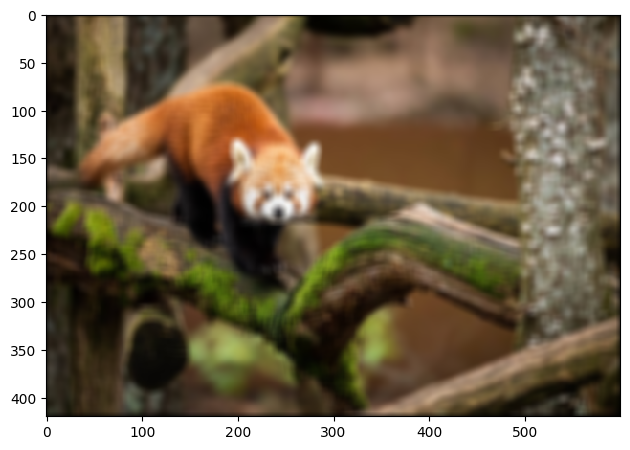

In [105]:
#filtr uśredniający
usredniajacy = np.array([[1, 2, 1], [1, 4, 1], [1, 2, 1]]) / 16
usredniajacy = np.ones([9, 9]) / (9 ** 2)
po_filtracji = np.dstack([
    convolve(obraz[:, :, kanal], usredniajacy, mode="constant", cval=0.0)
    for kanal in range(3)
])
io.imshow(po_filtracji)

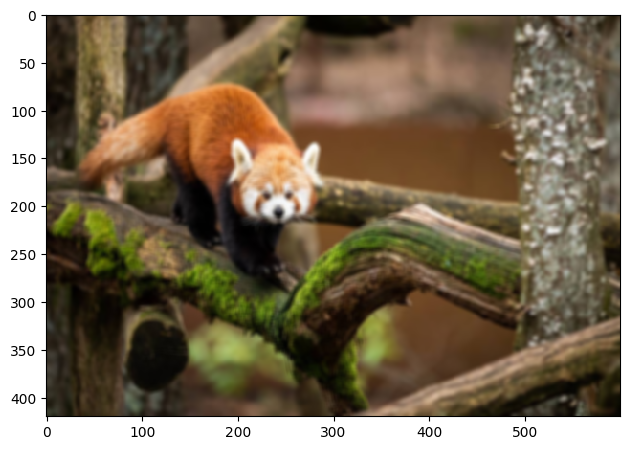

In [106]:
def pobierz_blur(rozmiar: int):
    return np.ones([rozmiar, rozmiar]) / (rozmiar ** 2)
blur = pobierz_blur(rozmiar=5)
obraz_po_konwolucji = konwolucja_z_krokami(obraz, blur)
_ = io.imshow(obraz_po_konwolucji)

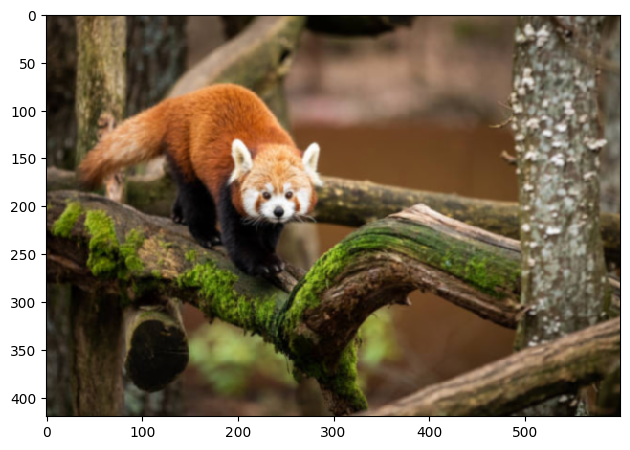

In [110]:
def blur(rozmiar: int) -> NDArray: #robi średnią pikseli
    return np.ones((rozmiar, rozmiar)) / (rozmiar**2)

def gaus_blur(rozmiar: int, sigma: float = 1.0) -> NDArray: #średnia lokalna ważona funkcja gęstości prawdopodobieństwa rozkładu normalnego
    if rozmiar % 2 == 0:
        raise ValueError("musi być liczbą nieparzysta gdy filr gaussowski")
    def local_meshgrid(s: int): #lokalne meshgrid z daną wielkością skoncentrowaną w zerze, używając odległości Manhattan
        środek = s // 2
        return np.abs(np.arange(s) - środek) + np.abs(np.arange(s).reshape(-1, 1) - środek)

    gaussowskie = stats.multivariate_normal(np.zeros(2), sigma * np.eye(2))
    gaussowskie = gaussowskie.pdf(np.dstack([local_meshgrid(rozmiar), local_meshgrid(rozmiar)]))
    jadro = np.ones([rozmiar, rozmiar]) * gaussowskie
    return jadro / jadro.sum()  # znormalizuj 
blur = gaus_blur(rozmiar=7, sigma=1)  #zmieniasz rozmiar
obraz_po_konwolucji = konwolucja_z_krokami(obraz, blur)
_ = io.imshow(obraz_po_konwolucji)

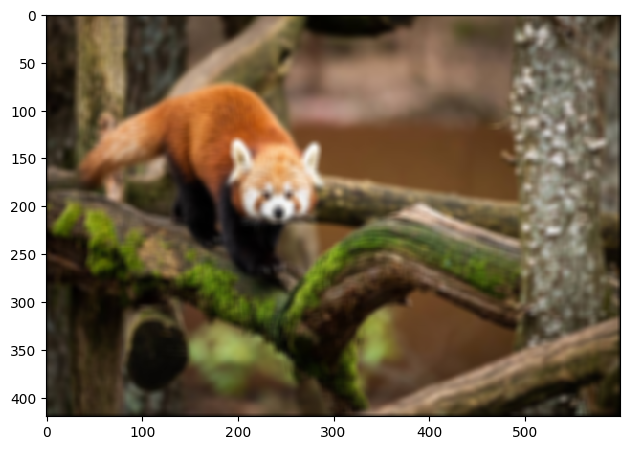

In [111]:
#rozmiar filtru do blurowania
rozmiar_filtru = 7  # zmiana rozmiaru jądra
usredniajacy = np.ones((rozmiar_filtru, rozmiar_filtru)) / (rozmiar_filtru ** 2)
po_filtracji = np.dstack([
    convolve(obraz[:, :, kanal], usredniajacy, mode="constant", cval=0.0)
    for kanal in range(3)
])

io.imshow(po_filtracji)

In [112]:
#wyostrzanie 1
obraz = io.imread("C:/Users/matiu/OneDrive/Pulpit/SiOC/Bayer/pand.jpg")
macierz_wyostrzajaca = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
obraz_wyostrzony = konwolucja_z_krokami(obraz, macierz_wyostrzajaca, krok=1, padding=0)

io.imshow_collection([obraz, obraz_wyostrzony])
io.show()

In [ ]:
#wyostrzanie 2 Laplace
def laplace_filter(obraz: np.ndarray, krok: int = 1, padding: int = 0) -> np.ndarray:
    #filtr Laplace'a jeszcze raz
    filtr_laplace = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    return konwolucja_z_krokami(obraz, filtr_laplace, krok, padding)

obraz_wyostrzony_laplace = laplace_filter(obraz, krok=1, padding=0)
io.imshow_collection([obraz, obraz_wyostrzony_laplace])
io.show()

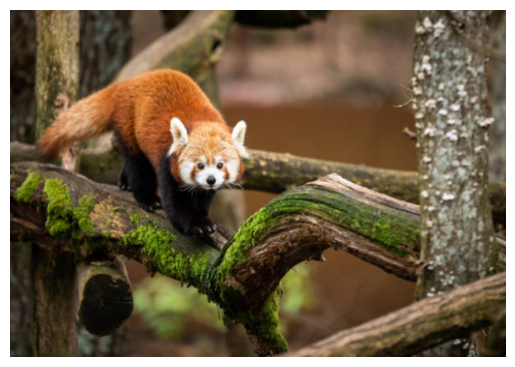

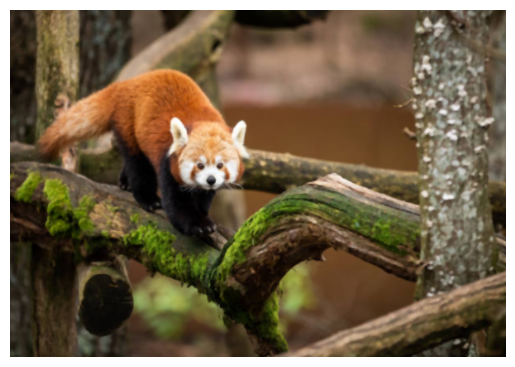

In [118]:
#usuwanie szumu filtr mediany
def usun_szum(obraz, rozmiar_filtra):
    odszumiony_obraz = np.zeros_like(obraz)
    for kanal in range(obraz.shape[2]):
        odszumiony_obraz[:, :, kanal] = median_filter(obraz[:, :, kanal], size=rozmiar_filtra)
    return odszumiony_obraz

#rozmiar filtra medianowego
rozmiar_filtra = 3
odszumiony = usun_szum(obraz, rozmiar_filtra)

#pierwszy obraz (zaszumiony obraz) 
plt.imshow(obraz)
plt.axis('off')
plt.show()
#drugi obraz (odszumiony obraz)
plt.imshow(odszumiony)
plt.axis('off')
plt.show()

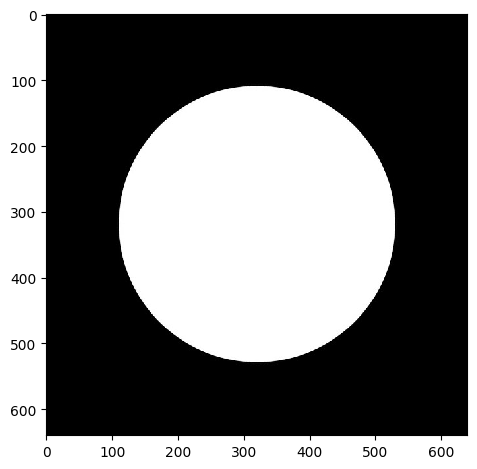

In [119]:
obraz = io.imread(r"C:/Users/matiu/OneDrive/Pulpit/SiOC/Bayer/circl.jpg")
obraz_szary = color.rgb2gray(obraz)

io.imshow(obraz)

In [127]:
#zrób wykres dla konkretnego operatoora
def generuj_wykres(obraz_rgb, krawedz_x, krawedz_y, polaczone_krawedzie, tytul):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(obraz_rgb)
    plt.title('Oryginal')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(krawedz_x, cmap='gray')
    plt.title(tytul + ' krawędzie X')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(krawedz_y, cmap='gray')
    plt.title(tytul + ' krawędzie Y')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(polaczone_krawedzie, cmap='gray')
    plt.title(tytul + ' razem')
    plt.axis('off')
    plt.show()

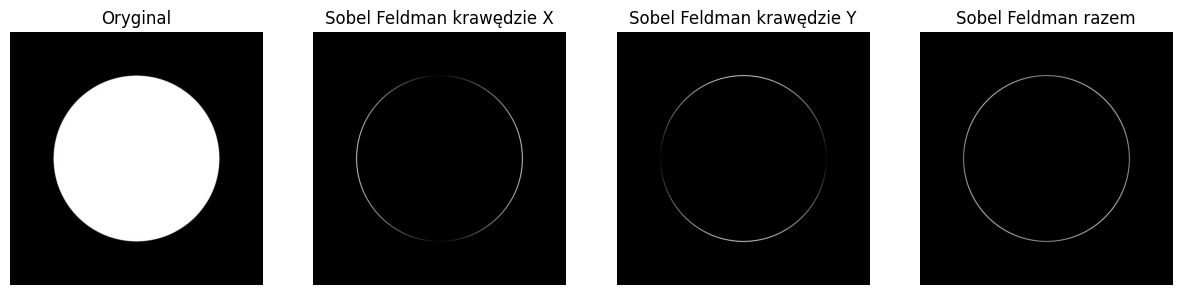

In [128]:
#operator Sobela-Feldmana
sobel_feldman_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_feldman_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

krawedziex_sf = np.abs(convolve(obraz_szary, sobel_feldman_x, mode="constant", cval=0.0))
krawedziey_sf = np.abs(convolve(obraz_szary, sobel_feldman_y, mode="constant", cval=0.0))
polaczone_sf = krawedziex_sf + krawedziey_sf
generuj_wykres(obraz, krawedziex_sf, krawedziey_sf, polaczone_sf, 'Sobel Feldman')

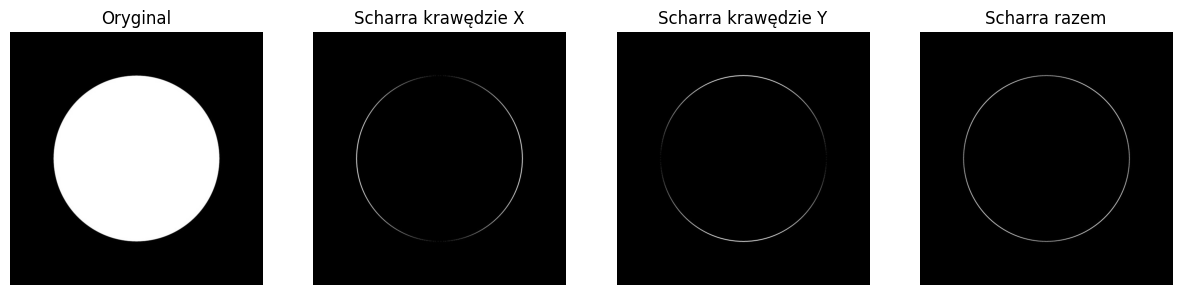

In [129]:
#operator Scharra
scharra_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])
scharra_y = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]])

krawedziex_scharra = np.abs(convolve(obraz_szary, scharra_x, mode="constant", cval=0.0))
krawedziey_scharra = np.abs(convolve(obraz_szary, scharra_y, mode="constant", cval=0.0))
polaczone_scharra = krawedziex_scharra + krawedziey_scharra
generuj_wykres(obraz, krawedziex_scharra, krawedziey_scharra, polaczone_scharra, 'Scharra')

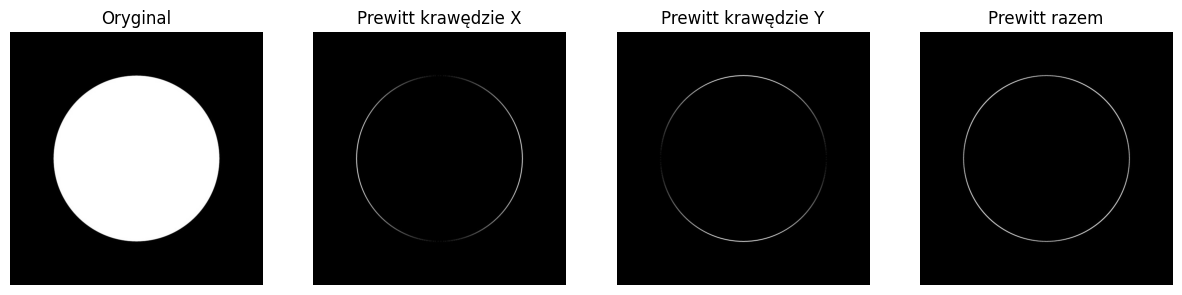

In [130]:
#operator Prewitta
prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

krawedziex_prewitt = np.abs(convolve(obraz_szary, prewitt_x, mode="constant", cval=0.0))
krawedziey_prewitt = np.abs(convolve(obraz_szary, prewitt_y, mode="constant", cval=0.0))
polaczone_prewitt = krawedziex_prewitt + krawedziey_prewitt
generuj_wykres(obraz, krawedziex_prewitt, krawedziey_prewitt, polaczone_prewitt, 'Prewitt')